In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from alphabase.spectral_library.base import SpecLibBase
from alphadia import data, planning
from alphadia.workflow import manager, peptidecentric

import git
def get_git_root():
    git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

POOL_PROJECTS="/fs/pool/pool-mann-projects/"
POOL_MS="/Volumes/My Passport for Mac/alphadia_data/"
PROJECT_FOLDER=f"{get_git_root()}/"

RAW_FOLDER = f"{POOL_MS}"
LIBRARY_FOLDER=f"{POOL_MS}libraries/"
OUTPUT_FOLDER=f"{PROJECT_FOLDER}debugging_files/"

POOL_PROJECTS="/fs/pool/pool-mann-projects/"
POOL_MS="/fs/pool/pool-mann-ms14/"
PROJECT_FOLDER=f"{POOL_PROJECTS}despard/hpo/hpo_mse_2024_07_09/"

RAW_FOLDER = f"{POOL_MS}/Astral4/2024_07/"
LIBRARY_FOLDER=f"{PROJECT_FOLDER}libraries/"
OUTPUT_FOLDER=f"{PROJECT_FOLDER}output/"

In [5]:
import tempfile

#test_folder = tempfile.mkdtemp()

# uncomment the following line to use a specific folder
test_folder = "debugging_files"
#
# library_path
#
# raw_data_path_list = [
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw",
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_06.raw",
#   "/Users/georgwallmann/Documents/data/alphadia_performance_tests/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw",
# ]

# HeLa library as used in the getting started guide
library_url = "https://datashare.biochem.mpg.de/s/Uw2yfNSbApfPpTk"

# Bulk injections of HeLa cell lysate acquired on the Orbitrap Astral
raw_data_url_list = [
    "https://datashare.biochem.mpg.de/s/339jg5HtGrwLwDN/download?files=20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw",
    ]

from alphadia.test_data_downloader import DataShareDownloader

library_path = DataShareDownloader(library_url,test_folder).download()
raw_data_path_list = [DataShareDownloader(url,test_folder).download() for url in raw_data_url_list]

debugging_files/hela_hybrid.hdf does not yet exist


100% |########################################################################|


hela_hybrid.hdf successfully downloaded to debugging_files/hela_hybrid.hdf


debugging_files/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw does not yet exist


20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw successfully downloaded to debugging_files/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05.raw


In [6]:
MODE = "astral"

if MODE == "astral":
    raw_files = [
        os.path.join(
            RAW_FOLDER,
            "20240704_OA4_Evo11_16p3min_PaSk_SA_HYE_1002575_200ng_noF_03.raw",
        )
    ]
    output_location = os.path.join(OUTPUT_FOLDER, "debugging/")
    os.makedirs(output_location, exist_ok=True)
    fasta_path_list = [os.path.join(LIBRARY_FOLDER, x) for x in ["2024_02_21_human.fasta", "2024_02_21_yeast.fasta", "2024_02_21_ecoli.fasta"]]
elif MODE == "timstof":
    raw_files = [
        os.path.join(
            performance_test_folder,
            "raw_data/timstof_lf_diap/20230502_TIMS05_PaSk_SA_HeLa_21min_diaP_12scans_S2-A3_1_2089.d",
        )
    ]
    output_location = os.path.join(
        performance_test_folder, "outputs/timstof_lf_diaPASEF"
    )
    speclib_path = os.path.join(
        performance_test_folder,
        "libraries/timstof/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_egs.hdf",
    )
else:
    raise ValueError("Unknown mode")

In [7]:
config = {
    "general": {
        "reuse_calibration": False,
        "reuse_quant": False,
        "thread_count": 10,
        "astral_ms1": False,
    },
    "search_advanced": {
        "top_k_fragments_scoring": 12,
    },
    "search": {
        "target_num_candidates": 5,
        "target_ms1_tolerance": 0.1 if MODE == "astral" else 15,
        "target_ms2_tolerance": 0.1 if MODE == "astral" else 15,
        "target_rt_tolerance": 1,
        "max_epochs" : 7,
    },
    "fdr": {"classifier": "legacy"},

    "library_prediction": {
      "predict": False,
      "enzyme": 'trypsin',
      "fixed_modifications": 'Carbamidomethyl@C',
      "variable_modifications": 'Oxidation@M;Acetyl@Protein N-term',
      "max_var_mod_num": 1,
      "missed_cleavages": 0,
      "precursor_len": [7, 35],
      "precursor_charge": [2, 4],
      "precursor_mz": [380, 980],
      "fragment_mz": [200, 2000],
      "nce": 25,
      "instrument": 'Lumos',
      "save_hdf": True,
    },
    "search_initial": {
      # Number of peak groups identified in the convolution score to classify with target decoy comeptition
      "initial_num_candidates": 1,
    
      # initial ms1 tolerance in ppm
      "initial_ms1_tolerance": 100,
    
      # initial ms2 tolerance in ppm
      "initial_ms2_tolerance": 100,
    
      # initial retention time tolerance in seconds
      "initial_rt_tolerance": 600,
    },
    "calibration":{
        "recalibration_target" : 50,
        "param_calibration_order" : [['ms2'], ['rt'], ['ms1', 'mobility']],
    }
}

#speclib_path = f"{LIBRARY_FOLDER}speclib.hdf"

In [8]:
#plan = planning.Plan(output_location, raw_files, fasta_path_list=fasta_path_list, config=config)
#plan = planning.Plan(output_location, raw_files, speclib_path, config=config)
plan = planning.Plan(test_folder, raw_data_path_list, library_path, config=config)

0:00:00.002782 PROGRESS:           _      _         ___ ___   _   
0:00:00.005688 PROGRESS:      __ _| |_ __| |_  __ _|   \_ _| /_\  
0:00:00.006413 PROGRESS:     / _` | | '_ \ ' \/ _` | |) | | / _ \ 
0:00:00.006706 PROGRESS:     \__,_|_| .__/_||_\__,_|___/___/_/ \_\
0:00:00.006996 PROGRESS:            |_|                           
0:00:00.007283 PROGRESS: 
0:00:00.007655 PROGRESS: version: 1.7.2
0:00:00.008273 PROGRESS: hostname: Oscars-MacBook-Air-4.local
0:00:00.009569 PROGRESS: date: 2024-07-19 15:03:09
0:00:00.009834 PROGRESS: =================== Environment ===================
0:00:00.010484 PROGRESS: alphatims       : 1.0.8
0:00:00.010772 PROGRESS: alpharaw        : 0.4.5
0:00:00.011061 PROGRESS: alphabase       : 1.2.5
0:00:00.011357 PROGRESS: alphapeptdeep   : 1.2.1
0:00:00.011624 PROGRESS: directlfq       : 0.2.19
0:00:00.011928 PROGRESS: ===================================================
0:00:00.012566 INFO: loading default config from /Users/odespard/projects/git/alphadia

In [9]:
for raw_name, dia_path, speclib in plan.get_run_data():
    pass

0:00:34.110482 PROGRESS: Loading raw file 1/1: 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05


In [10]:
workflow = peptidecentric.PeptideCentricWorkflow(
    raw_name,
    plan.config,
)


0:00:34.164754 INFO: Creating parent folder for workflows at debugging_files/.progress
0:00:34.165522 INFO: Creating workflow folder for 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05 at debugging_files/.progress/20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05


Testing again!


In [11]:
workflow.load(dia_path, speclib)

49it [01:16,  1.57s/it]
0:02:05.147437 INFO: Determining DIA cycle
0:02:05.978362 INFO: Found cycle with start 0.00 min and length 301.
0:02:08.229141 INFO: ============ Raw file stats ============
0:02:08.254326 INFO: RT (min)            : 0.0 - 20.9
0:02:08.254957 INFO: RT duration (sec)   : 1253.3
0:02:08.263925 INFO: RT duration (min)   : 20.9
0:02:08.268585 INFO: Cycle len (scans)   : 301
0:02:08.269558 INFO: Cycle len (sec)     : 1.55
0:02:08.270144 INFO: Number of cycles    : 806
0:02:08.276302 INFO: MS2 range (m/z)     : 380.4 - 980.7
0:02:08.281336 INFO: ========================================
0:02:10.743414 INFO: Initializing CalibrationManager
0:02:10.746206 INFO: Loading calibration config
0:02:10.748339 INFO: Calibration config: [{'name': 'fragment', 'estimators': [{'name': 'mz', 'model': 'LOESSRegression', 'model_args': {'n_kernels': 2}, 'input_columns': ['mz_library'], 'target_columns': ['mz_observed'], 'output_columns': ['mz_calibrated'], 'transform_deviation': '1e6'}]

In [26]:
workflow.initialize_managers()

1:47:06.374493 PROGRESS: Initializing workflow 20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_05
1:47:06.393647 INFO: Initializing OptimizationManager
1:47:06.394595 INFO: initial parameter: current_epoch = 0
1:47:06.395113 INFO: initial parameter: current_step = 0
1:47:06.395527 INFO: initial parameter: ms1_error = 100
1:47:06.395887 INFO: initial parameter: ms2_error = 100
1:47:06.396291 INFO: initial parameter: rt_error = 600
1:47:06.396665 INFO: initial parameter: mobility_error = 0.08
1:47:06.398665 INFO: initial parameter: column_type = library
1:47:06.399906 INFO: initial parameter: num_candidates = 1
1:47:06.400456 INFO: initial parameter: recalibration_target = 50
1:47:06.400890 INFO: initial parameter: accumulated_precursors = 0
1:47:06.402252 INFO: initial parameter: accumulated_precursors_01FDR = 0
1:47:06.403444 INFO: initial parameter: accumulated_precursors_001FDR = 0
1:47:06.403984 INFO: initial parameter: fitted_params = []
1:47:06.425522 INFO: initial parameter

1:47:16.465986 INFO: Fitting ['ms2'].
1:47:16.469221 INFO: === checking if epoch conditions were reached ===
1:47:16.470074 INFO:  ms2_error      : 100.0000 > 0.1
1:47:16.470716 INFO: ❌ current_epoch  : 0 < 2
1:47:16.471343 INFO: ==============================================


hello


1:48:11.820289 INFO: calibration group: precursor, predicting mz
1:48:11.836437 WARNING: mz prediction was skipped as it has not been fitted yet
1:48:11.837938 INFO: calibration group: precursor, predicting rt
1:48:11.839821 WARNING: rt prediction was skipped as it has not been fitted yet
1:48:11.842195 INFO: calibration group: fragment, predicting mz
1:48:17.047288 PROGRESS: === Epoch 0, step 0, extracting elution groups 0 to 8000 ===
1:48:18.143194 PROGRESS: Extracting batch of 15899 precursors
1:48:18.441124 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:48:18.441802 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:48:18.445133 INFO: FWHM in RT is 2.92 seconds, sigma is 0.40
1:48:18.446216 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
1:48:18.546571 INFO: Starting candidate selection
100%|██████████| 15899/15899 [00:12<00:00, 1305.14it/s]
1:48:36.831098 INFO: Starting candidate scoring
100%|██████████| 15897/15897 [00:02<00:00, 6278.60it/s]

Using base classifier


100%|██████████| 252/252 [00:00<00:00, 382403.98it/s]
1:48:50.371864 INFO: Test AUC: 0.614
1:48:50.372908 INFO: Train AUC: 0.602
1:48:50.373348 INFO: AUC difference: 1.95%


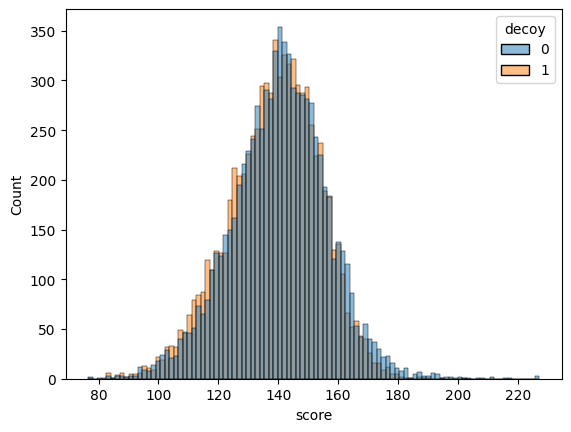

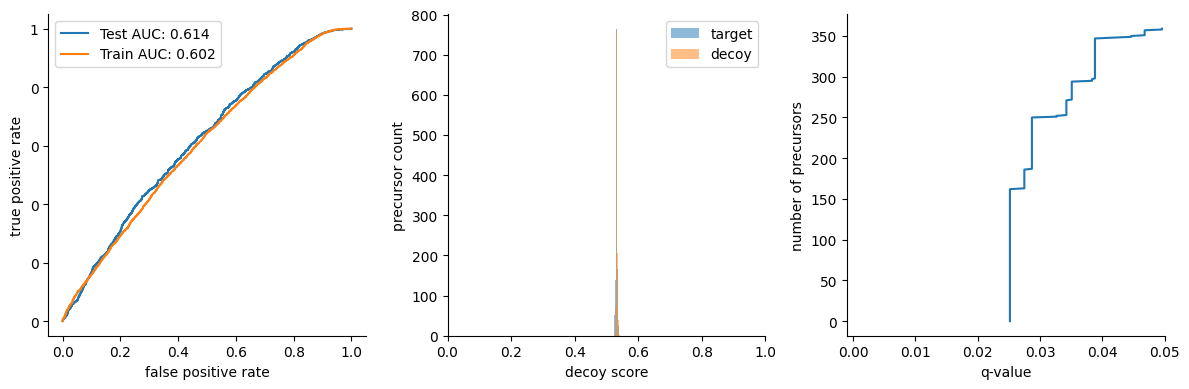

1:48:51.703543 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:48:51.713393 PROGRESS: ============================= Precursor FDR =============================
1:48:51.715379 PROGRESS: Total precursors accumulated: 630
1:48:51.716166 PROGRESS: Target precursors: 579 (91.90%)
1:48:51.716900 PROGRESS: Decoy precursors: 51 (8.10%)
1:48:51.717579 PROGRESS: 
1:48:51.718213 PROGRESS: Precursor Summary:
1:48:51.727449 PROGRESS: Channel   0:	 0.05 FDR:   343; 0.01 FDR:     0; 0.001 FDR:     0
1:48:51.729449 PROGRESS: 
1:48:51.731407 PROGRESS: Protein Summary:
1:48:51.743459 PROGRESS: Channel   0:	 0.05 FDR:   301; 0.01 FDR:     0; 0.001 FDR:     0
1:48:51.745807 PROGRESS: =========================================================================
1:48:51.752436 PROGRESS: === Epoch 0, step 1, extracting elution groups 8000 to 24000 ===


Storing classifier: 1dbbc056e05895b0


1:48:52.106873 PROGRESS: Extracting batch of 31823 precursors
1:48:52.171662 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:48:52.172408 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:48:52.173353 INFO: FWHM in RT is 2.92 seconds, sigma is 0.40
1:48:52.173872 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
1:48:52.188767 INFO: Starting candidate selection
100%|██████████| 31823/31823 [00:20<00:00, 1570.31it/s]
1:49:16.458130 INFO: Starting candidate scoring
100%|██████████| 31823/31823 [00:02<00:00, 11447.88it/s]
1:49:21.307128 INFO: Finished candidate processing
1:49:21.312771 INFO: Collecting candidate features
1:49:23.158760 INFO: Collecting fragment features
1:49:23.428198 INFO: Finished candidate scoring
1:49:24.209805 PROGRESS: === Epoch 0, step 1, extracted 31823 precursors and 361692 fragments ===
1:49:24.219286 INFO: performing precursor FDR with 47 features
1:49:24.219939 INFO: Decoy channel: -1
1:49:24.220324 INFO: Competetive: True

Using classifier: 1dbbc056e05895b0


100%|██████████| 299/299 [00:00<00:00, 22133.73it/s]
1:49:26.249282 INFO: Test AUC: 0.634
1:49:26.249961 INFO: Train AUC: 0.637
1:49:26.250464 INFO: AUC difference: 0.34%


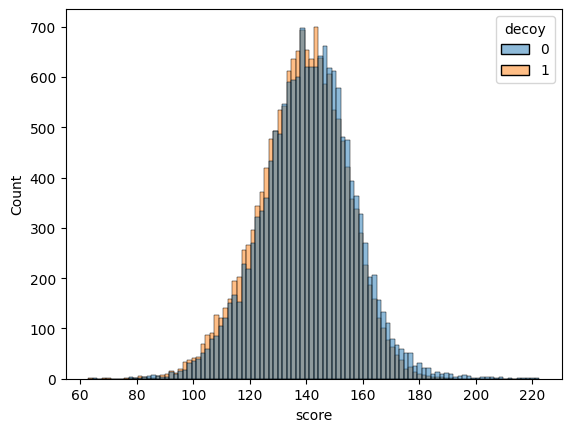

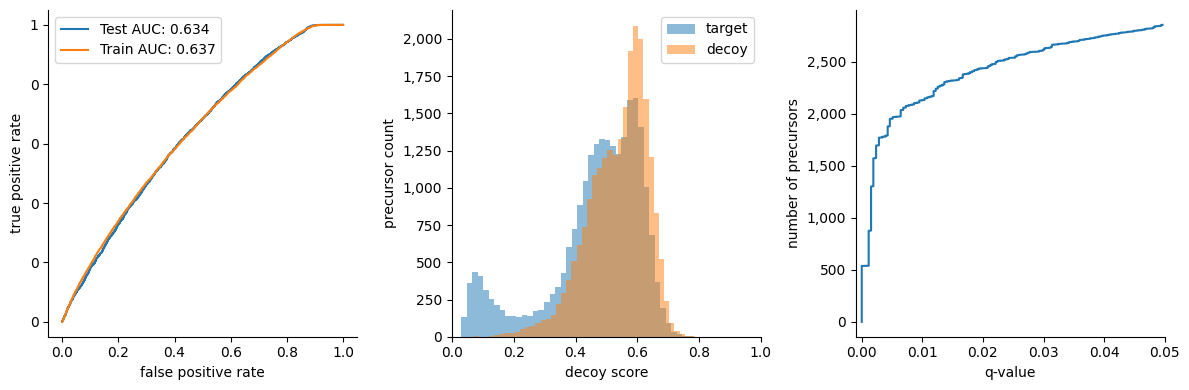

1:49:27.469450 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:49:27.475927 PROGRESS: ============================= Precursor FDR =============================
1:49:27.476908 PROGRESS: Total precursors accumulated: 3,300
1:49:27.477513 PROGRESS: Target precursors: 3,038 (92.06%)
1:49:27.478212 PROGRESS: Decoy precursors: 262 (7.94%)
1:49:27.478751 PROGRESS: 
1:49:27.479470 PROGRESS: Precursor Summary:
1:49:27.485371 PROGRESS: Channel   0:	 0.05 FDR: 2,719; 0.01 FDR: 2,109; 0.001 FDR:   538
1:49:27.487429 PROGRESS: 
1:49:27.488010 PROGRESS: Protein Summary:
1:49:27.500512 PROGRESS: Channel   0:	 0.05 FDR: 1,764; 0.01 FDR: 1,412; 0.001 FDR:   452
1:49:27.501713 PROGRESS: =========================================================================
1:49:27.585079 INFO: calibration group: fragment, fitting mz estimator 


Storing classifier: 1dbbc056e05895b0
fragments_df_filtered: 500


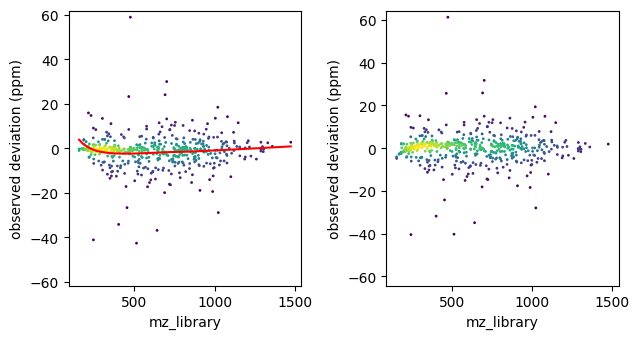

1:49:28.534945 INFO: === checking if epoch conditions were reached ===
1:49:28.537348 INFO:  ms2_error      : 32.5289 > 0.1
1:49:28.538162 INFO: ❌ current_epoch  : 0 < 2
1:49:28.539932 INFO: ==============================================
1:49:28.542016 INFO: calibration group: precursor, predicting mz
1:49:28.543445 WARNING: mz prediction was skipped as it has not been fitted yet
1:49:28.544542 INFO: calibration group: precursor, predicting rt
1:49:28.545367 WARNING: rt prediction was skipped as it has not been fitted yet
1:49:28.545947 INFO: calibration group: fragment, predicting mz


score cutoff 98.36404495239258
hello


1:49:31.540262 PROGRESS: === Epoch 1, step 0, extracting elution groups 0 to 24000 ===
1:49:32.001152 PROGRESS: Extracting batch of 47722 precursors
1:49:32.103959 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:49:32.104648 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:49:32.105728 INFO: FWHM in RT is 3.82 seconds, sigma is 0.52
1:49:32.107060 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
1:49:32.123862 INFO: Starting candidate selection
100%|██████████| 47722/47722 [00:31<00:00, 1505.37it/s]
1:50:07.605586 INFO: Starting candidate scoring
100%|██████████| 238600/238600 [00:15<00:00, 15806.20it/s]
1:50:30.767117 INFO: Finished candidate processing
1:50:30.775788 INFO: Collecting candidate features
1:50:36.803485 INFO: Collecting fragment features
1:50:38.215144 INFO: Finished candidate scoring
1:50:39.732766 PROGRESS: === Epoch 1, step 0, extracted 238599 precursors and 2576390 fragments ===
1:50:39.738810 INFO: performing precursor FDR wit

Using classifier: 1dbbc056e05895b0


100%|██████████| 300/300 [00:00<00:00, 21517.71it/s]
1:50:50.265598 INFO: Test AUC: 0.615
1:50:50.267838 INFO: Train AUC: 0.621
1:50:50.268288 INFO: AUC difference: 0.98%


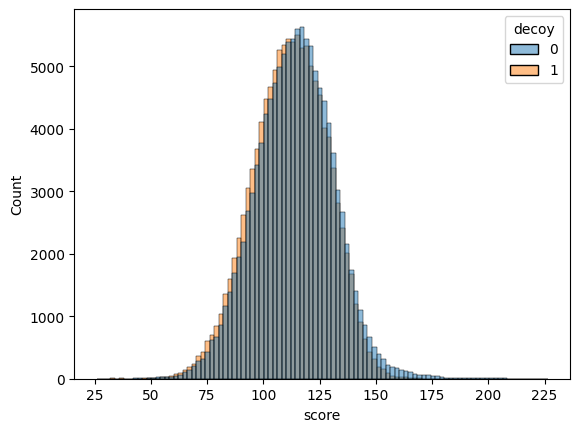

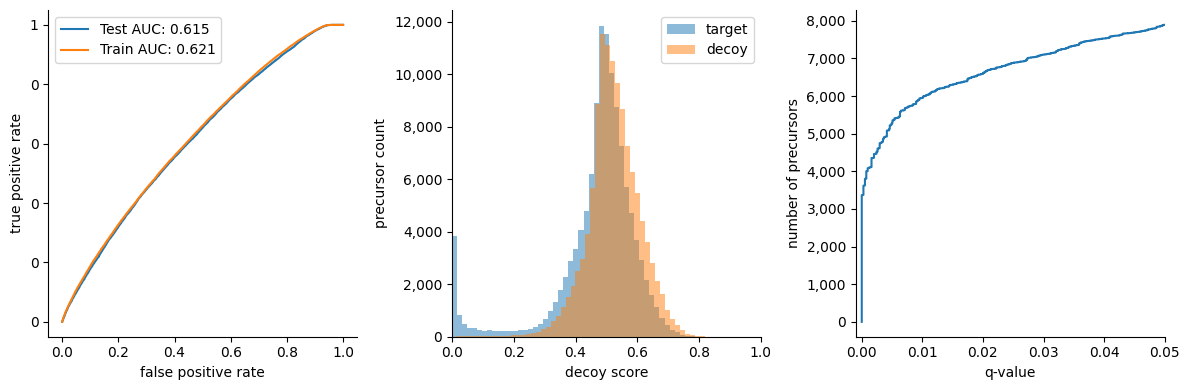

1:50:52.094548 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:50:52.109040 PROGRESS: ============================= Precursor FDR =============================
1:50:52.110263 PROGRESS: Total precursors accumulated: 8,349
1:50:52.111240 PROGRESS: Target precursors: 7,837 (93.87%)
1:50:52.111826 PROGRESS: Decoy precursors: 512 (6.13%)
1:50:52.112285 PROGRESS: 
1:50:52.112931 PROGRESS: Precursor Summary:
1:50:52.129094 PROGRESS: Channel   0:	 0.05 FDR: 7,516; 0.01 FDR: 5,890; 0.001 FDR: 4,080
1:50:52.129956 PROGRESS: 
1:50:52.130326 PROGRESS: Protein Summary:
1:50:52.143586 PROGRESS: Channel   0:	 0.05 FDR: 4,051; 0.01 FDR: 3,319; 0.001 FDR: 2,487
1:50:52.145083 PROGRESS: =========================================================================


Storing classifier: 03a2f02d595f0537


1:50:53.086282 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


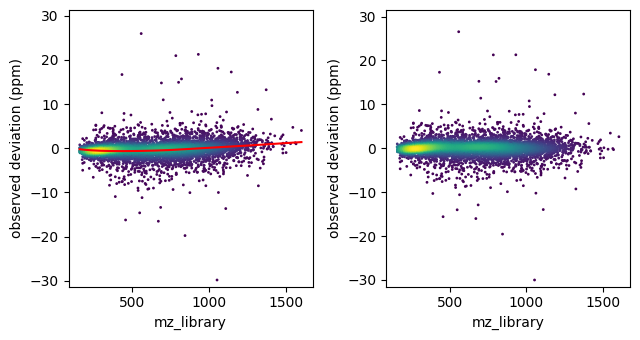

1:50:54.415071 INFO: === checking if epoch conditions were reached ===
1:50:54.417534 INFO:  ms2_error      : 7.9114 > 0.1
1:50:54.419048 INFO: ❌ current_epoch  : 1 < 2
1:50:54.420016 INFO: ==============================================
1:50:54.420743 INFO: calibration group: precursor, predicting mz
1:50:54.421641 WARNING: mz prediction was skipped as it has not been fitted yet
1:50:54.422733 INFO: calibration group: precursor, predicting rt
1:50:54.423445 WARNING: rt prediction was skipped as it has not been fitted yet
1:50:54.423880 INFO: calibration group: fragment, predicting mz


score cutoff 82.81833799743653
hello


1:50:56.209113 PROGRESS: === Epoch 2, step 0, extracting elution groups 0 to 24000 ===
1:50:56.826930 PROGRESS: Extracting batch of 47722 precursors
1:50:57.101426 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:50:57.104060 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:50:57.200479 INFO: FWHM in RT is 3.59 seconds, sigma is 0.49
1:50:57.201528 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
1:50:57.213974 INFO: Starting candidate selection
100%|██████████| 47722/47722 [00:34<00:00, 1390.71it/s]
1:51:35.552321 INFO: Starting candidate scoring
100%|██████████| 238600/238600 [00:17<00:00, 13494.31it/s]
1:51:57.069727 INFO: Finished candidate processing
1:51:57.085248 INFO: Collecting candidate features
1:51:59.930367 WARNING: intensity_correlation has 20 NaNs ( 0.01 % out of 238474)
1:52:00.017283 INFO: Collecting fragment features
1:52:01.295499 INFO: Finished candidate scoring
1:52:04.732555 PROGRESS: === Epoch 2, step 0, extracted 238474 prec

Using classifier: 1dbbc056e05895b0


1:52:05.736196 WARNING: dropped 10 target PSMs due to missing features
1:52:05.736938 WARNING: dropped 10 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 23006.44it/s]
1:52:18.923403 INFO: Test AUC: 0.625
1:52:18.926674 INFO: Train AUC: 0.633
1:52:18.927160 INFO: AUC difference: 1.34%


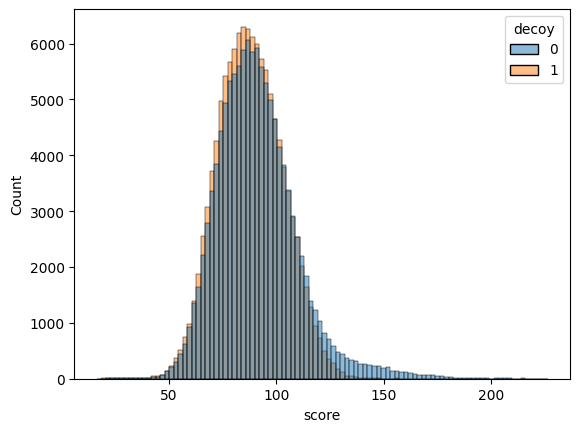

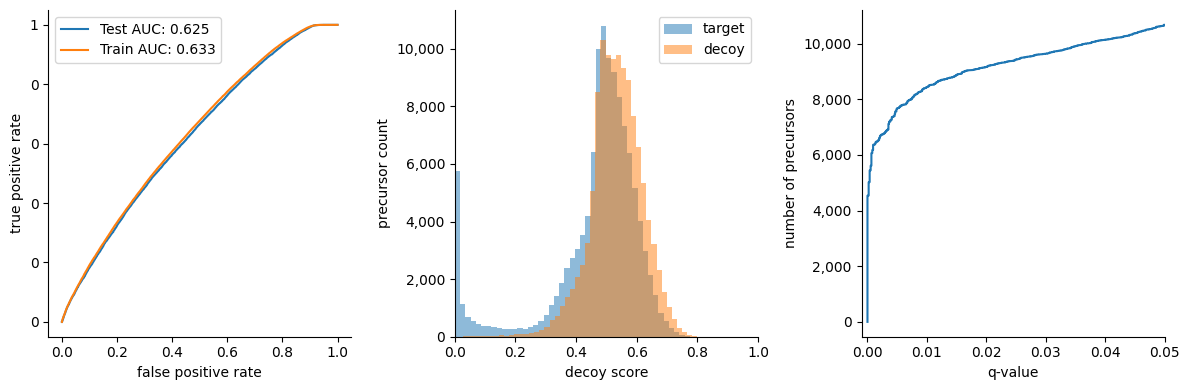

1:52:20.884974 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:52:20.906227 PROGRESS: ============================= Precursor FDR =============================
1:52:20.907273 PROGRESS: Total precursors accumulated: 10,797
1:52:20.907744 PROGRESS: Target precursors: 10,244 (94.88%)
1:52:20.908336 PROGRESS: Decoy precursors: 553 (5.12%)
1:52:20.908846 PROGRESS: 
1:52:20.910613 PROGRESS: Precursor Summary:
1:52:20.935694 PROGRESS: Channel   0:	 0.05 FDR: 10,168; 0.01 FDR: 8,353; 0.001 FDR: 6,359
1:52:20.936737 PROGRESS: 
1:52:20.937305 PROGRESS: Protein Summary:
1:52:20.994694 PROGRESS: Channel   0:	 0.05 FDR: 4,920; 0.01 FDR: 4,295; 0.001 FDR: 3,531
1:52:20.995668 PROGRESS: =========================================================================


Storing classifier: 48aa7ecdb550b9c3


1:52:22.065647 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


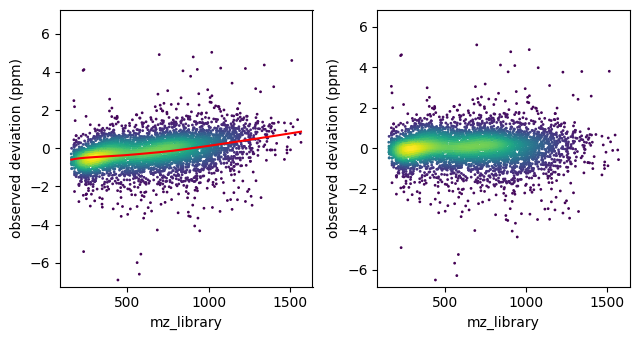

1:52:23.239260 INFO: === checking if epoch conditions were reached ===
1:52:23.240766 INFO:  ms2_error      : 3.0625 > 0.1
1:52:23.241570 INFO: ✅ current_epoch  : 2 >= 2
1:52:23.242302 INFO: ==============================================
1:52:23.248648 INFO: calibration group: precursor, predicting mz
1:52:23.250115 WARNING: mz prediction was skipped as it has not been fitted yet
1:52:23.251139 INFO: calibration group: precursor, predicting rt
1:52:23.252275 WARNING: rt prediction was skipped as it has not been fitted yet
1:52:23.254745 INFO: calibration group: fragment, predicting mz


score cutoff 66.31282006835937


1:52:24.878649 PROGRESS: === Epoch 3, step 0, extracting elution groups 0 to 24000 ===
1:52:25.305968 PROGRESS: Extracting batch of 47722 precursors
1:52:25.444311 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:52:25.445109 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:52:25.446166 INFO: FWHM in RT is 3.12 seconds, sigma is 0.43
1:52:25.446618 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
1:52:25.460437 INFO: Starting candidate selection
100%|██████████| 47722/47722 [00:40<00:00, 1176.64it/s]
1:53:12.931533 INFO: Starting candidate scoring
100%|██████████| 238600/238600 [00:22<00:00, 10585.04it/s]
1:53:39.892932 INFO: Finished candidate processing
1:53:39.915720 INFO: Collecting candidate features
1:53:49.726324 WARNING: intensity_correlation has 84 NaNs ( 0.04 % out of 237309)
1:53:51.254692 INFO: Collecting fragment features
1:53:54.954214 INFO: Finished candidate scoring
1:54:04.469725 PROGRESS: === Epoch 3, step 0, extracted 237309 prec

Using classifier: 1dbbc056e05895b0


1:54:07.632954 WARNING: dropped 47 target PSMs due to missing features
1:54:07.636137 WARNING: dropped 37 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 19732.95it/s]
1:54:26.844653 INFO: Test AUC: 0.624
1:54:27.029855 INFO: Train AUC: 0.628
1:54:27.032771 INFO: AUC difference: 0.66%


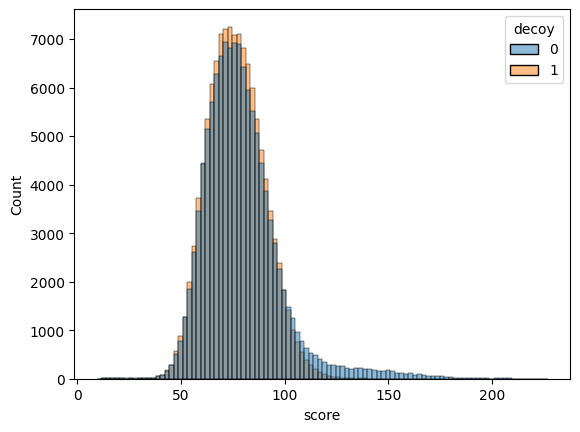

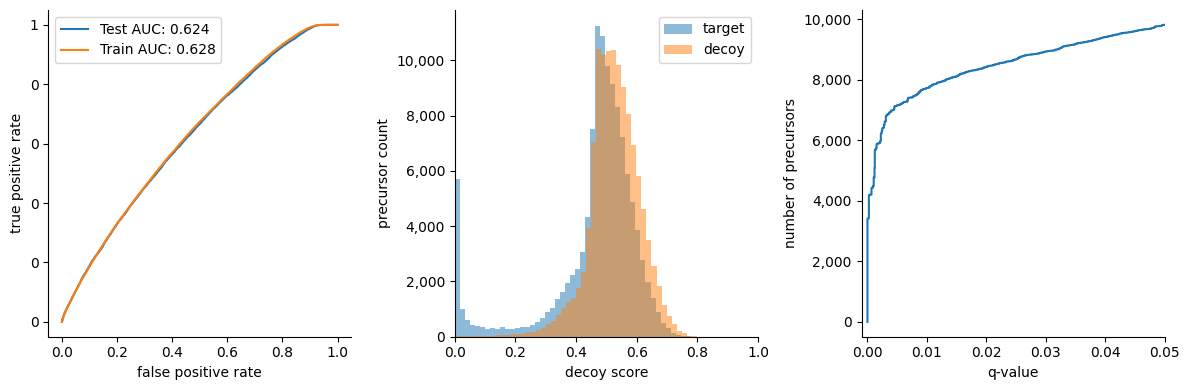

1:54:29.043806 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:54:29.051950 PROGRESS: ============================= Precursor FDR =============================
1:54:29.052918 PROGRESS: Total precursors accumulated: 9,977
1:54:29.053529 PROGRESS: Target precursors: 9,460 (94.82%)
1:54:29.054105 PROGRESS: Decoy precursors: 517 (5.18%)
1:54:29.054693 PROGRESS: 
1:54:29.055198 PROGRESS: Precursor Summary:
1:54:29.067575 PROGRESS: Channel   0:	 0.05 FDR: 9,354; 0.01 FDR: 7,657; 0.001 FDR: 4,482
1:54:29.069211 PROGRESS: 
1:54:29.070407 PROGRESS: Protein Summary:
1:54:29.093523 PROGRESS: Channel   0:	 0.05 FDR: 4,678; 0.01 FDR: 4,057; 0.001 FDR: 2,711
1:54:29.094626 PROGRESS: =========================================================================


Storing classifier: 6bdd73c377b402e5


1:54:29.546378 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


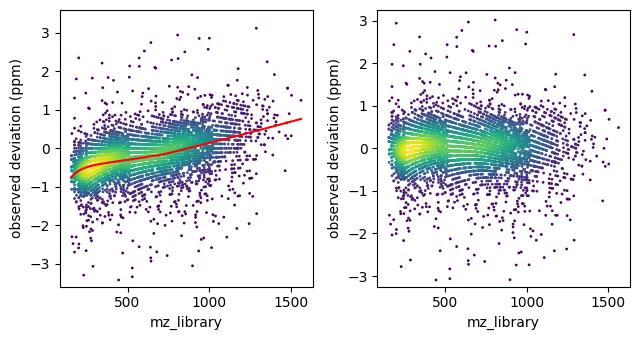

score cutoff 57.71999923706055


1:54:31.532130 INFO: === checking if epoch conditions were reached ===
1:54:31.535811 INFO:  ms2_error      : 2.1940 > 0.1
1:54:31.541729 INFO: ✅ current_epoch  : 3 >= 2
1:54:31.601931 INFO: ==============================================
1:54:31.628878 INFO: calibration group: precursor, predicting mz
1:54:31.632125 WARNING: mz prediction was skipped as it has not been fitted yet
1:54:31.633016 INFO: calibration group: precursor, predicting rt
1:54:31.634346 WARNING: rt prediction was skipped as it has not been fitted yet
1:54:31.638152 INFO: calibration group: fragment, predicting mz
1:54:34.473657 PROGRESS: === Epoch 4, step 0, extracting elution groups 0 to 24000 ===
1:54:35.361052 PROGRESS: Extracting batch of 47722 precursors
1:54:36.034472 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
1:54:36.050095 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
1:54:36.069318 INFO: FWHM in RT is 2.76 seconds, sigma is 0.38
1:54:36.081515 INFO: FWHM in mobility 

Using classifier: 1dbbc056e05895b0


1:56:10.641044 WARNING: dropped 133 target PSMs due to missing features
1:56:10.643911 WARNING: dropped 143 decoy PSMs due to missing features
100%|██████████| 300/300 [00:00<00:00, 17509.34it/s]
1:56:23.856993 INFO: Test AUC: 0.618
1:56:23.858832 INFO: Train AUC: 0.624
1:56:23.859403 INFO: AUC difference: 1.03%


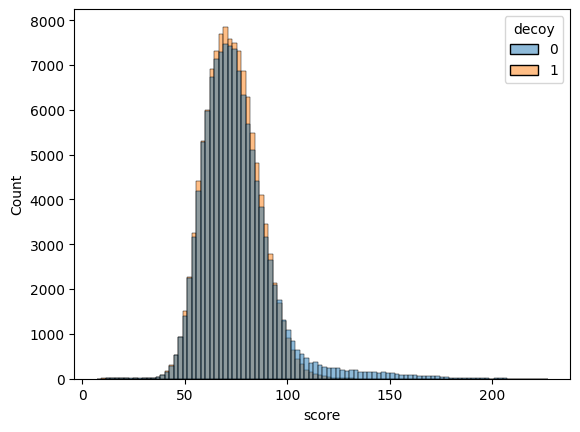

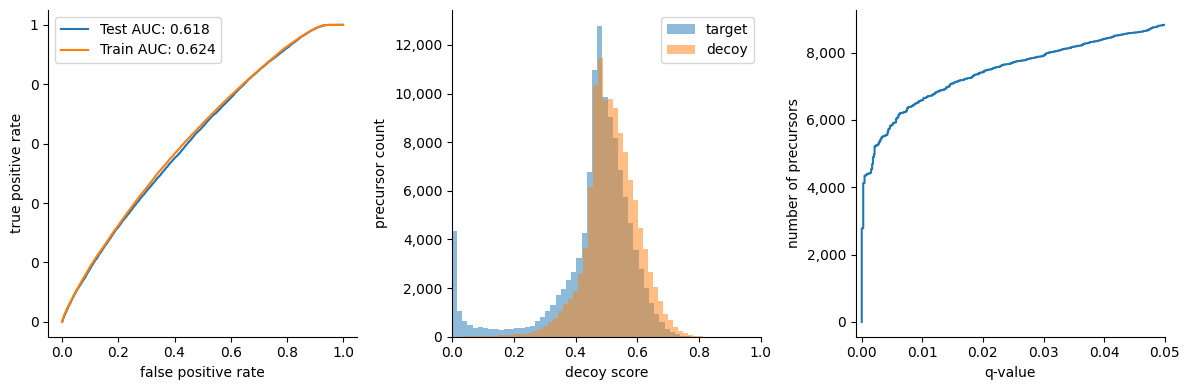

1:56:25.462399 PROGRESS: === checking if recalibration conditions were reached, target 50 precursors ===
1:56:25.487113 PROGRESS: ============================= Precursor FDR =============================
1:56:25.488455 PROGRESS: Total precursors accumulated: 9,035
1:56:25.489398 PROGRESS: Target precursors: 8,562 (94.76%)
1:56:25.490899 PROGRESS: Decoy precursors: 473 (5.24%)
1:56:25.492103 PROGRESS: 
1:56:25.492958 PROGRESS: Precursor Summary:
1:56:25.509111 PROGRESS: Channel   0:	 0.05 FDR: 8,404; 0.01 FDR: 6,520; 0.001 FDR: 4,396
1:56:25.510312 PROGRESS: 
1:56:25.511738 PROGRESS: Protein Summary:
1:56:25.528591 PROGRESS: Channel   0:	 0.05 FDR: 4,374; 0.01 FDR: 3,584; 0.001 FDR: 2,661
1:56:25.529578 PROGRESS: =========================================================================


Storing classifier: 9ac56118ad360ae9


1:56:25.715090 INFO: calibration group: fragment, fitting mz estimator 


fragments_df_filtered: 5000


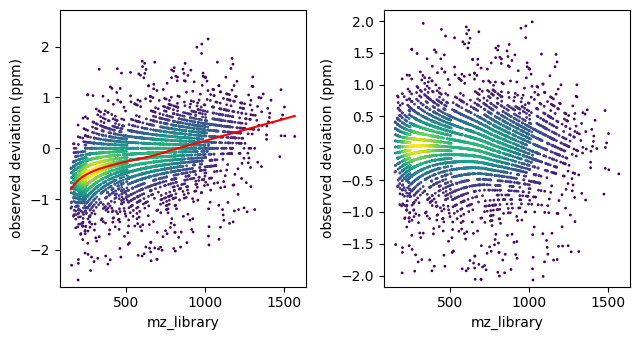

1:56:27.126487 INFO: === checking if epoch conditions were reached ===
1:56:27.129482 INFO:  ms2_error      : 1.8124 > 0.1
1:56:27.131683 INFO: ✅ current_epoch  : 4 >= 2
1:56:27.133177 INFO: ==============================================


score cutoff 55.48463867950439
4
hello


2:00:19.393283 PROGRESS: Optimal value for ms2 is 7.9113683921123075.


In [27]:
workflow.calibration(param_calibration_order = [['ms2'], ['rt'], ['ms1', 'mobility']])

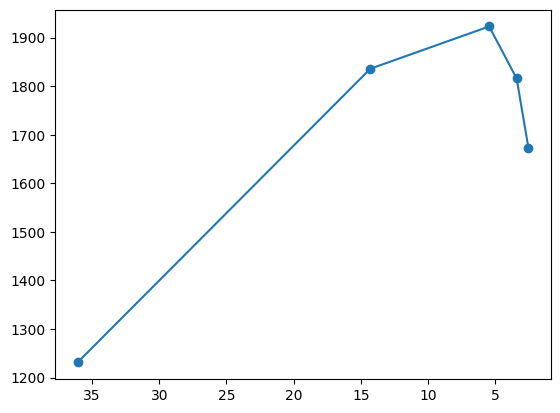

In [91]:
fig, ax = plt.subplots()
ax.plot(workflow.com.ms2_list[1:6], workflow.com.precursor_number[1:6], linestyle='-')
ax.scatter(workflow.com.ms2_list[1:6], workflow.com.precursor_number[1:6])
ax.invert_xaxis()
plt.savefig("debugging_files/ms2_plot.png", dpi=300)
plt.show()

0:46:18.222662 INFO: calibration group: precursor, predicting mz
0:46:18.699327 INFO: calibration group: precursor, predicting rt
0:46:19.212572 INFO: calibration group: fragment, predicting mz
0:46:21.199798 PROGRESS: Extracting batch of 481467 precursors
0:46:22.166090 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
0:46:22.167055 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
0:46:22.168246 INFO: FWHM in RT is 3.06 seconds, sigma is 0.42
0:46:22.168897 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
0:46:22.180865 INFO: Starting candidate selection
100%|██████████| 481467/481467 [03:04<00:00, 2611.28it/s]
0:49:38.518982 INFO: Applying score cutoff of 41.38192577362061
0:49:39.792369 INFO: Removed 624002 precursors with score below cutoff
0:49:43.388250 INFO: Starting candidate scoring
100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]
0:51:20.960183 INFO: Finished candidate processing
0:51:20.986615 INFO: Collecting candidate features
0:51:41.5

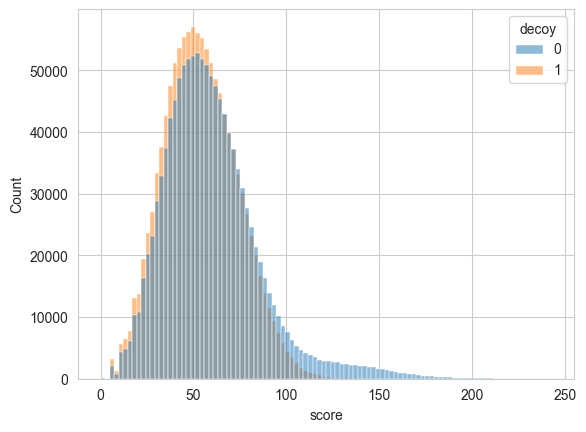

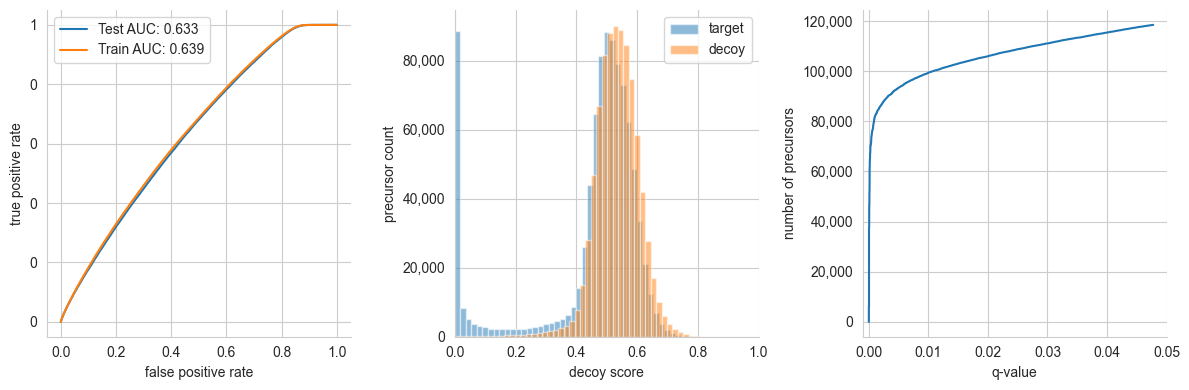

0:53:50.416393 INFO: Removing fragments below FDR threshold
0:53:52.505206 PROGRESS: ============================= Precursor FDR =============================
0:53:52.520319 PROGRESS: Total precursors accumulated: 99,339
0:53:52.521444 PROGRESS: Target precursors: 98,356 (99.01%)
0:53:52.522378 PROGRESS: Decoy precursors: 983 (0.99%)
0:53:52.523137 PROGRESS: 
0:53:52.523748 PROGRESS: Precursor Summary:
0:53:52.596824 PROGRESS: Channel   0:	 0.05 FDR: 98,356; 0.01 FDR: 98,356; 0.001 FDR: 81,618
0:53:52.597826 PROGRESS: 
0:53:52.598484 PROGRESS: Protein Summary:
0:53:52.705212 PROGRESS: Channel   0:	 0.05 FDR: 10,314; 0.01 FDR: 10,314; 0.001 FDR: 9,346
0:53:52.752980 PROGRESS: =========================================================================


(        base_width_mobility  base_width_rt  rt_observed  mobility_observed  \
 71337                   0.0      23.299622   679.788635           0.000001   
 92122                   0.0      20.210022   873.802917           0.000001   
 98268                   0.0      35.635681   796.254944           0.000001   
 26874                   0.0      29.484314   693.778687           0.000001   
 81602                   0.0      20.201294   484.358032           0.000001   
 ...                     ...            ...          ...                ...   
 1300                    0.0      10.838318   797.801331           0.000001   
 100804                  0.0      10.822876   588.340332           0.000001   
 77650                   0.0      13.951904   689.128296           0.000001   
 55103                   0.0      10.815002   654.966003           0.000001   
 110320                  0.0      17.057251   667.354980           0.000001   
 
         mono_ms1_intensity  top_ms1_intensity  su

In [12]:
workflow.extraction()

In [14]:
from alphadia.peakgroup import search  # Changed this; original was from alphadia import hybridselection

config = search.HybridCandidateConfig()
config.update(workflow.config["selection_config"])
config.update(
    {
        "rt_tolerance": workflow.com.rt_error,
        "mobility_tolerance": workflow.com.mobility_error,
        "candidate_count": workflow.com.num_candidates,
        "precursor_mz_tolerance": workflow.com.ms1_error,
        "fragment_mz_tolerance": workflow.com.ms2_error,
        "exclude_shared_ions": workflow.config["search"]["exclude_shared_ions"],
    }
)

extraction = search.HybridCandidateSelection(
    workflow.dia_data.jitclass(),
    test_df,
    workflow.spectral_library.fragment_df,
    config.jitclass(),
    rt_column=f"rt_{workflow.com.column_type}",
    mobility_column=f"mobility_{workflow.com.column_type}",
    precursor_mz_column=f"mz_{workflow.com.column_type}",
    fragment_mz_column=f"mz_{workflow.com.column_type}",
    fwhm_rt=workflow.optimization_manager.fwhm_rt,
    fwhm_mobility=workflow.optimization_manager.fwhm_mobility,
)
candidates_df = extraction(thread_count=workflow.config["general"]["thread_count"])

0:53:56.106614 INFO: Duty cycle consists of 301 frames, 1.55 seconds cycle time
0:53:56.107287 INFO: Duty cycle consists of 1 scans, 0.00000 1/K_0 resolution
0:53:56.108294 INFO: FWHM in RT is 3.06 seconds, sigma is 0.42
0:53:56.108704 INFO: FWHM in mobility is 0.000 1/K_0, sigma is 1.00
0:53:56.119786 INFO: Starting candidate selection


KeyError: 'mobility_calibrated'

In [ ]:
from alphadia import plexscoring

config = plexscoring.CandidateConfig()
config.update(workflow.config["scoring_config"])
config.update(
    {
        "precursor_mz_tolerance": workflow.com.ms1_error,
        "fragment_mz_tolerance": workflow.com.ms2_error,
        "exclude_shared_ions": workflow.config["search"]["exclude_shared_ions"],
    }
)

candidate_scoring = plexscoring.CandidateScoring(
    workflow.dia_data.jitclass(),
    workflow.spectral_library._precursor_df,
    workflow.spectral_library._fragment_df,
    config=config,
    rt_column=f"rt_{workflow.com.column_type}",
    mobility_column=f"mobility_{workflow.com.column_type}",
    precursor_mz_column=f"mz_{workflow.com.column_type}",
    fragment_mz_column=f"mz_{workflow.com.column_type}",
)

features_df, fragments_df = candidate_scoring(
    candidates_df,
    thread_count=workflow.config["general"]["thread_count"],
)